<h1>Importações de bibliotecas</h1>

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image
from IPython.display import clear_output
from PIL import Image
from operator import itemgetter

<h1>Definição das imagens utilizadas</h1>

In [2]:
#imagens = {'objeto':'martelo.png', 'imagem':'formas.png', 'saida':'martelos.png'}
#imagens = {'objeto':'chapeu2.jpg', 'imagem':'lena.jpg', 'saida':'chapeu.jpg'}
#imagens = {'objeto':'Input5Ref.png', 'imagem':'Input1.png', 'saida':'bule.png'}
#imagens = {'objeto':'grifo2.bmp', 'imagem':'ferramentas.bmp', 'saida':'grifo2.bmp'}
imagens = {'objeto':'chapeu2.jpg', 'imagem':'lena_oculta.jpg', 'saida':'chapeu2.jpg'}

<h1>Imagem do objeto</h1>

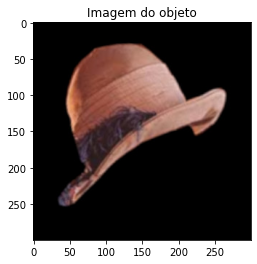

In [3]:
imgForm = imread(imagens['objeto'])
plt.imshow(imgForm)
plt.title('Imagem do objeto')
plt.show()

In [4]:
#obtendo bordas da imagem
def edgeImage(image):
    try:
        edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        edge_image = image
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
    edge_image = cv2.Canny(edge_image, 100, 200)
    return edge_image

#obtendo angulos da imagem
def angImage(image):
    try:
        edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        edge_image = image
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
    sobelx = cv2.Sobel(edge_image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(edge_image,cv2.CV_64F,0,1,ksize=5)
    aux = np.ndarray(shape=edge_image.shape, dtype=int)
    for i in range(aux.shape[0]):
        for j in range(aux.shape[1]):
            ang = np.round(np.arctan2(sobely[i,j], sobelx[i,j])* 180 / np.pi)
            if ang < 0:
                ang = 360 + ang
            aux[i,j] = ang
    return (sobelx, sobely, aux)
    
#obtendo centroide do objeto (a partir da imagem com as bordas)
def centroid(edge_image):
    xc = 0
    yc = 0
    qtde = 0
    for i in range(edge_image.shape[0]):
        for j in range(edge_image.shape[1]):
            if edge_image[i,j] != 0:
                xc = xc + i
                yc = yc + j
                qtde = qtde + 1
    xc = xc // qtde
    yc = yc // qtde
    return (xc, yc)

#Coordenadas cartesianas => Coordenadas polares
def coordPolar(x, y, xc, yc):
    r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
    alpha = np.arctan2(y - yc, x - xc)
    return (r, alpha)

#Obter ponto a partir das coordenadas cartesianas e os parâmetros de escala e rotação
def recoveryPoint(xc, yc, r, alpha, S, phi):
    phi = np.radians(phi)
    x = int(np.round(xc + r*S*np.cos(alpha+phi),0))
    y = int(np.round(yc + r*S*np.sin(alpha+phi),0))
    return (x, y)

#Obter o centroide a partir de um ponto, os pâmetros da Tabela-R e os parâmetros de escala e rotação
def getCentroid(x, y, r, alpha, S, phi):
    phi = np.radians(phi)
    xc = int(np.round(x - r*S*np.cos(alpha+phi),0))
    yc = int(np.round(y - r*S*np.sin(alpha+phi),0))
    return (xc, yc)

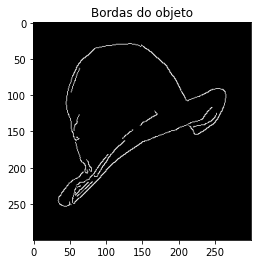

In [5]:
imgFormEdges = edgeImage(imgForm)
plt.imshow(imgFormEdges, cmap='gray')
plt.title('Bordas do objeto')
plt.show()

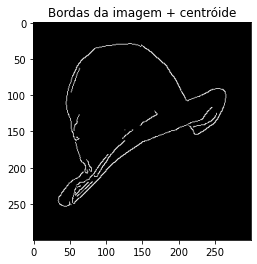

In [6]:
xc, yc = centroid(imgFormEdges)
aux = imgFormEdges
aux[xc, yc] = 255
plt.imshow(aux, cmap='gray')
plt.title('Bordas da imagem + centróide') #pourco visível dependendo do tamanho da imagem
plt.show()
aux[xc, yc] = 0

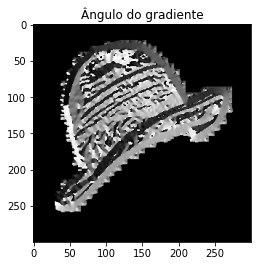

In [7]:
sx, sy, imgFormAng = angImage(imgForm)
plt.imshow(imgFormAng, cmap='gray')
plt.title('Ângulo do gradiente')
plt.show()

<h1>Imagem principal</h1>

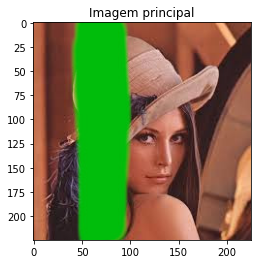

In [8]:
img = imread(imagens['imagem'])
plt.imshow(img)
plt.title('Imagem principal')
plt.show()

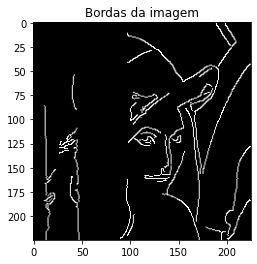

In [9]:
imgEdges = edgeImage(img)
plt.imshow(imgEdges, cmap='gray')
plt.title('Bordas da imagem')
plt.show()

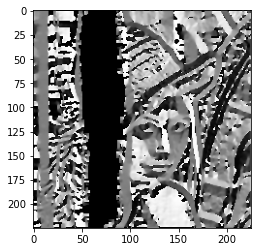

In [10]:
sx, sy, imgAng = angImage(img)
plt.imshow(imgAng, cmap='gray')
plt.show()
#np.unique(imgAng)

<h1>Construção da tabela-R</h1>

In [11]:
tabelaR = [[] for _ in range(360)]
for i in range(imgFormEdges.shape[0]):
    for j in range(imgFormEdges.shape[1]):
        if imgFormEdges[i,j] != 0:
            tabelaR[imgFormAng[i,j]].append(coordPolar(i, j, xc, yc))
        

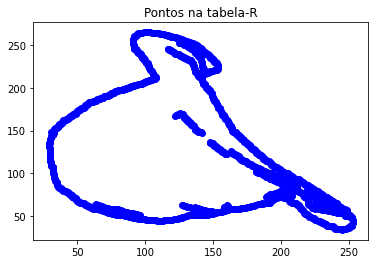

1486

In [12]:
totalEntradas = 0
for theta in range(360):
    for polar in tabelaR[theta]:
        totalEntradas = totalEntradas + 1
        px, py = recoveryPoint(xc, yc, polar[0], polar[1], 1, 0)
        plt.plot(px, py, 'bo')
plt.title('Pontos na tabela-R')
plt.show()
totalEntradas

<h1>Preparando matriz de acumulação</h1>

In [13]:
#definindo parâmetros de busca
xc_min = 0
xc_max = imgEdges.shape[0]-1

yc_min = 0
yc_max = imgEdges.shape[1]-1

S_min = 0.4
S_max = 2
S_inc = 0.3
S_len = int((S_max - S_min)/S_inc) + 1

phi_min = -10
phi_max = 10
phi_inc = 1
phi_len = (phi_max - phi_min)//phi_inc + 1

M = np.zeros(shape=(xc_max+1, yc_max+1, S_len, phi_len), dtype=int)
Mvis = np.zeros(shape=(xc_max+1, yc_max+1), dtype=int)
M.shape

(225, 225, 6, 21)

In [14]:
#funções auxiliares
def getS(pos):
    return np.round(S_min + pos*S_inc,1)

def getPhi(pos):
    return phi_min + pos*phi_inc

In [15]:
maiorValor = 0
for x in range(xc_min, xc_max):
    clear_output(wait=True)
    print(int(((x+1)/xc_max)*100),'%',sep='', flush=True)
    for y in range(yc_min, yc_max):
        #para cada ponto
        if imgEdges[x,y] != 0:
            #se é ponto de borda
            theta = imgAng[x,y]
            for spos in range(S_len):
                for phiPos in range(phi_len):
                    phi = getPhi(phiPos)
                    newTheta = (theta + phi) % 360 #talvez precise pensar melhor sobre isso
                    #newTheta = theta
                    for p in tabelaR[newTheta]:
                        xcPos, ycPos = getCentroid(x, y, p[0], p[1], getS(spos), phi)
                        if xc_min < xcPos < xc_max and yc_min < ycPos < yc_max:
                            M[xcPos, ycPos, spos, phiPos] = M[xcPos, ycPos, spos, phiPos]+4
                            #pensando em erros de aproximação
                            M[xcPos+1, ycPos, spos, phiPos] = M[xcPos+1, ycPos, spos, phiPos]+1
                            M[xcPos-1, ycPos, spos, phiPos] = M[xcPos-1, ycPos, spos, phiPos]+1
                            M[xcPos, ycPos+1, spos, phiPos] = M[xcPos, ycPos+1, spos, phiPos]+1
                            M[xcPos, ycPos-1, spos, phiPos] = M[xcPos, ycPos-1, spos, phiPos]+1
                            maiorValor = max(maiorValor, M[xcPos, ycPos, spos, phiPos], M[xcPos+1, ycPos, spos, phiPos], M[xcPos-1, ycPos, spos, phiPos], M[xcPos, ycPos+1, spos, phiPos], M[xcPos, ycPos-1, spos, phiPos])
                            Mvis[xcPos, ycPos] = Mvis[xcPos, ycPos] + 1


100%


In [16]:
np.unique(M)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        81,  82,  83,  84,  85,  86,  87,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 102, 104, 105, 106, 107, 108, 113, 117,
       128, 129, 131, 132, 136, 139, 142, 146, 150, 152, 154, 171, 176,
       179, 180, 215, 233, 244, 264, 290])

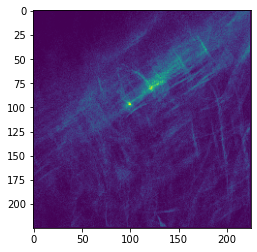

In [17]:
plt.imshow(Mvis)

<h1>Encontrando objeto na imagem</h1>

In [18]:
#Lista com possíveis localizações do objeto
objetosTodos = []
limiarInferior = 50
#Percorrendo a matriz de acumulação
for x in range(xc_min, xc_max):
    clear_output(wait=True)
    print(int(((x+1)/xc_max)*100),'%',sep='', flush=True)
    for y in range(yc_min, yc_max):
        for spos in range(S_len):
            for phiPos in range(phi_len):
                phi = getPhi(phiPos)
                if M[x, y, spos, phiPos] > limiarInferior:
                    objetosTodos.append([M[x, y, spos, phiPos], x, y, getS(spos), phi])
objetosTodos = sorted(objetosTodos, key=itemgetter(0), reverse=True)

100%


In [19]:
limiar = maiorValor - 1
#limiar = 200

#Objetos selecionados
objetos = []
for obj in objetosTodos:
    if obj[0] > limiar:
        objetos.append(obj[1:])
    else:
        break
print('Localizações dos objetos (xc, yc, S, phi):')
print(objetos)

Localizações dos objetos (xc, yc, S, phi):
[[97, 100, 0.7, 9]]


<h1>Mostrando objeto na imagem original</h1>

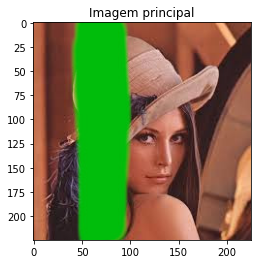

In [20]:
try:
    imgFinal = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
except:
    imgFinal = img.copy()
plt.imshow(imgFinal)
plt.title('Imagem principal')
plt.show()

In [21]:
for obj in objetos:
    obj_xc, obj_yc, obj_S, obj_phi = obj
    try:
        imgFinal[obj_xc, obj_yc] = (255,0,0)
    except:
        imgFinal[obj_xc, obj_yc] = (255,0,0, 255) #para imagens com canal alpha
    for theta in range(360):
        for polar in tabelaR[theta]:
            px, py = recoveryPoint(obj_xc, obj_yc, polar[0], polar[1], obj_S, obj_phi)
            if 0 <= px < imgFinal.shape[0] and 0 <= py < imgFinal.shape[1]:
                try:
                    imgFinal[px, py] = (255,0,0)
                except:
                    imgFinal[px, py] = (255,0,0, 255)

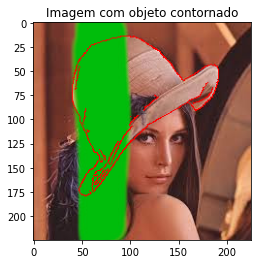

In [22]:
plt.imshow(imgFinal)
plt.title('Imagem com objeto contornado')
plt.show()

In [23]:
imSave = Image.fromarray(imgFinal)
imSave.save('resultados/' + imagens['saida'])